#EECS 504 PS5: Scene Recognition

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

[Mohammadreza] [Tavasoli Naeini], [tavasoli]

__Important__: after you download the .ipynb file, please name it as __\<your_uniquename\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101
Using the GPU!


# Problem 5.1 Scene Recognition with VGG

You will build and train a convolutional neural network for scene recognition, i.e., classifying images into different scenes. You will need to:
1. Contruct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. (Optional) Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [ ]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab. 
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2020-12-26 10:33:50--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip.1’

data_miniplaces_mod 100%[===================>] 509.86M  11.1MB/s    in 46s     

2020-12-26 10:34:36 (11.1 MB/s) - ‘data_miniplaces_modified.zip.1’ saved [534628730/534628730]



In [ ]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient. 
!unzip -q data_miniplaces_modified.zip

replace data_miniplaces_modified/test/badlands/00000399.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/data_miniplaces_modified/test/badlands/._00000399.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Step 1: Build dataloaders for train, val, and test

In [ ]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    '''
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.

    '''

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #  

    # ========= Step 1: build transformations for the dataset ===========
    # You need to construct build a data transformation that does three preprocessings in order:
    # I. Resize the image to input_size using transforms.Resize
    # II. Convert the image to PyTorch tensor using transforms.ToTensor
    # III. Normalize the images with the provided mean and std parameters using transforms.Normalize. These parameters are accumulated from a large number of training samples.
    # You can use transforms.Compose to combine the above three transformations. 
    transform=transforms.Compose([
     transforms.Resize(input_size),
        transforms.ToTensor(),transforms.Normalize(mean,std)
                          ])


    # ========= Step 2: build dataloaders for the downloaded data ===========
    # I. use torchvision.datasets.ImageFolder with the provided data_dir and the data transfomations you created in step 1 to contruct pytorch datasets for train/val/test 
    # II. use torch.utils.data.DataLoader to build dataloaders with the constructed pytorch datasets, you need to enable shuffling for training set. Set num_workers=2 to speed up dataloading.
    # III. put the dataloaders into a dictionary
    dataloaders_dict={}
    datatrain=torchvision.datasets.ImageFolder('data_miniplaces_modified/train', transform=transform)
    datatest=torchvision.datasets.ImageFolder('data_miniplaces_modified/test', transform=transform)
    dataval=torchvision.datasets.ImageFolder('data_miniplaces_modified/val', transform=transform)
    dataloaders_dict['train']=torch.utils.data.DataLoader(datatrain, batch_size=batch_size, shuffle=True, num_workers=2)
    dataloaders_dict['test']=torch.utils.data.DataLoader(datatest, batch_size=batch_size, shuffle=True, num_workers=2)
    dataloaders_dict['val']=torch.utils.data.DataLoader(dataval, batch_size=batch_size, shuffle=True, num_workers=2)


    
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return dataloaders_dict

In [ ]:
 batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 90000
# of validation samples 10000
# of test samples 10000


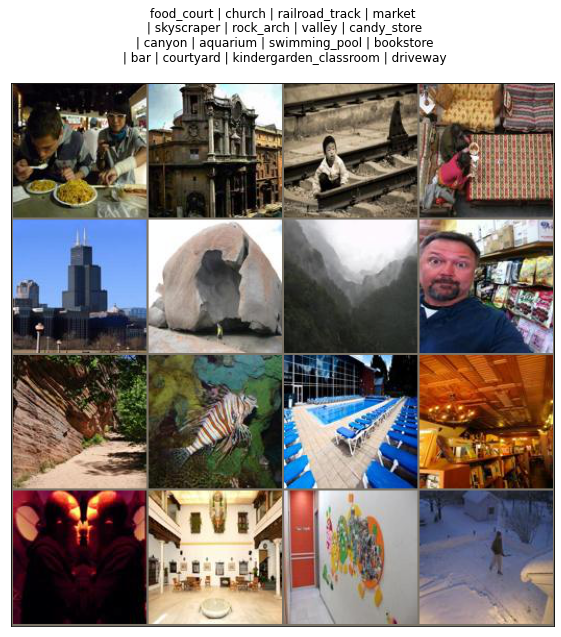

In [ ]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## Step 2. Build MiniVGG and MiniVGG-BN

Please follow the instructions to build the two neural networks with architectures shown below.

__MiniVGG architecture__

![](https://drive.google.com/uc?id=1RF3CjEsHBpRjubqwgBUxIEv54gpDjt95)

__MiniVGG-BN architecure__

![](https://drive.google.com/uc?id=1HR5N2V-5RVT1u_bVzyCvhPJZ7PSnYm6x)


In [ ]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    '''

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [ ]:
# Network configurations for all layers before the final fully-connected layers. 
# "M" corresponds to maxpooling layer, integers correspond to number of output channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):

    '''
    Return a nn.Sequential object containing all layers before the fully-connected layers in the VGG11 network. 

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction layers. For use of torch.nn.Sequential, please refer to PyTorch documents.
    '''
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    if batch_norm:
            features=nn.Sequential(nn.Conv2d(3,64,kernel_size=(3,3),stride=(1,1),padding=(1,1)), nn.BatchNorm2d(64) , nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1),
               nn.Conv2d(64,128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),nn.BatchNorm2d(128),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1),
               nn.Conv2d(128,128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),nn.BatchNorm2d(128),nn.ReLU(inplace=True),
               nn.Conv2d(128,128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),nn.BatchNorm2d(128),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1)
               )

    else:
      features=nn.Sequential(nn.Conv2d(3,64,kernel_size=(3,3),stride=(1,1),padding=(1,1)) , nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1),
               nn.Conv2d(64,128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1),
               nn.Conv2d(128,128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),nn.ReLU(inplace=True),
               nn.Conv2d(128,128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1)
               )
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        # Construct the final FC layers using nn.Sequential. 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== # 
        self.classifier = nn.Sequential(nn.Linear(in_features=3200,out_features=512,bias=True),nn.ReLU(inplace=True),nn.Dropout(p=0.3),
                                     nn.Linear(in_features=512,out_features=256,bias=True),nn.ReLU(inplace=True),nn.Dropout(p=0.3),
                                     nn.Linear(in_features=256,out_features=num_classes,bias=True))
        
        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

        if init_weights:
            self._initialize_weights()

    def forward(self, x): 
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with the one given in the instruction above. 
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=Tru

## Step 3: Build training/validation loops

You will write a function for training and validating the network. 

In [ ]:
def make_optimizer(model):
    '''
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    '''
    # Create an Adam optimizer with a learning rate 1e-3
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return optimizer

def get_loss():
    '''
    Returns:
        criterion: pytorch loss. 
    '''

    # Create an instance of the cross entropy loss function
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    # The code should be a one-liner.
    criterion = nn.CrossEntropyLoss()
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return criterion

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    '''
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    '''

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients 
                optimizer.zero_grad()
                
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 
                # ============== YOUR CODE HERE ============== #
                # For "train" phase, compute the outputs, calculate the loss, update the model parameters
                # For "val" phase, compute the outputs, calculate the loss
                if phase=='train':
                  outputs=model(inputs)
                  loss=criterion(outputs,labels.data)
                  loss.backward()
                  optimizer.step()
                else:
                  outputs=model(inputs)
                  loss=criterion(outputs,labels.data)
                preds= torch.max(outputs,1)[1]
                #print(labels)
                #print(preds)


                # ============== END OF CODE ================= # 
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
         

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # ================================ IMPORTANT ===============================================
                # Lossing connection to colab will lead to loss of trained weights.
                # You can download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to train the neural networks again.
                # ==========================================================================================
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## Step 4. Train MiniVGG and MiniVGG-BN

In [ ]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training 
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 5

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloders and criterion function
input_size = 64 # do not change this
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [ ]:
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')


  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/4
----------



100%|██████████| 704/704 [01:18<00:00,  8.96it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 4.0870 Acc: 0.0634



100%|██████████| 79/79 [00:08<00:00,  9.33it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.7511 Acc: 0.1056
Epoch 1/4
----------



100%|██████████| 704/704 [01:20<00:00,  8.80it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.5261 Acc: 0.1472



100%|██████████| 79/79 [00:08<00:00,  9.43it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.2658 Acc: 0.1877
Epoch 2/4
----------



100%|██████████| 704/704 [01:19<00:00,  8.83it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.2770 Acc: 0.1905



100%|██████████| 79/79 [00:08<00:00,  9.39it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.1312 Acc: 0.2164
Epoch 3/4
----------



100%|██████████| 704/704 [01:20<00:00,  8.78it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.1078 Acc: 0.2231



100%|██████████| 79/79 [00:08<00:00,  9.34it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9937 Acc: 0.2513
Epoch 4/4
----------



100%|██████████| 704/704 [01:19<00:00,  8.83it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.9836 Acc: 0.2470



100%|██████████| 79/79 [00:08<00:00,  9.30it/s]

val Loss: 2.9568 Acc: 0.2582
Best val Acc: 0.258200


In [ ]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')










  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/19
----------











  0%|          | 1/704 [00:00<04:22,  2.67it/s]








  0%|          | 3/704 [00:00<03:28,  3.36it/s]








  1%|          | 5/704 [00:00<02:42,  4.29it/s]








  1%|          | 7/704 [00:00<02:16,  5.11it/s]








  1%|▏         | 9/704 [00:01<01:59,  5.82it/s]








  2%|▏         | 11/704 [00:01<01:44,  6.65it/s]








  2%|▏         | 13/704 [00:01<01:37,  7.09it/s]








  2%|▏         | 15/704 [00:01<01:24,  8.18it/s]








  2%|▏         | 17/704 [00:02<01:17,  8.87it/s]








  3%|▎         | 19/704 [00:02<01:18,  8.73it/s]








  3%|▎         | 21/704 [00:02<01:17,  8.78it/s]








  3%|▎         | 23/704 [00:02<01:18,  8.71it/s]








  4%|▎         | 25/704 [00:02<01:17,  8.73it/s]








  4%|▍         | 27/704 [00:03<01:18,  8.63it/s]








  4%|▍         | 29/704 [00:03<01:17,  8.74it/s]








  4%|▍         | 31/704 [00:03<01:14,  9.03it/s]








  5%|▍         | 33/704 [00:03<01:13,  9.11it/s]








  5%|▍         | 35/704 [00

train Loss: 4.6139 Acc: 0.0107











  1%|▏         | 1/79 [00:00<00:23,  3.26it/s]








  4%|▍         | 3/79 [00:00<00:18,  4.11it/s]








  6%|▋         | 5/79 [00:00<00:14,  4.99it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.96it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.81it/s]








 14%|█▍        | 11/79 [00:01<00:08,  7.61it/s]








 16%|█▋        | 13/79 [00:01<00:07,  8.26it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.60it/s]








 22%|██▏       | 17/79 [00:01<00:07,  8.82it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.31it/s]








 27%|██▋       | 21/79 [00:02<00:06,  9.63it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.86it/s]








 32%|███▏      | 25/79 [00:02<00:05, 10.36it/s]








 34%|███▍      | 27/79 [00:02<00:04, 10.64it/s]








 37%|███▋      | 29/79 [00:02<00:04, 10.51it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.48it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.30it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.69it

val Loss: 4.6162 Acc: 0.0100
Epoch 1/19
----------











  0%|          | 1/704 [00:00<04:11,  2.80it/s]








  0%|          | 3/704 [00:00<03:18,  3.53it/s]








  1%|          | 5/704 [00:00<02:39,  4.39it/s]








  1%|          | 7/704 [00:00<02:09,  5.40it/s]








  1%|▏         | 9/704 [00:01<01:47,  6.49it/s]








  1%|▏         | 10/704 [00:01<01:46,  6.52it/s]








  2%|▏         | 12/704 [00:01<01:38,  7.05it/s]








  2%|▏         | 14/704 [00:01<01:29,  7.74it/s]








  2%|▏         | 16/704 [00:01<01:23,  8.19it/s]








  3%|▎         | 18/704 [00:02<01:19,  8.62it/s]








  3%|▎         | 19/704 [00:02<01:17,  8.88it/s]








  3%|▎         | 21/704 [00:02<01:17,  8.85it/s]








  3%|▎         | 23/704 [00:02<01:17,  8.81it/s]








  4%|▎         | 25/704 [00:02<01:10,  9.60it/s]








  4%|▍         | 27/704 [00:03<01:06, 10.18it/s]








  4%|▍         | 29/704 [00:03<01:09,  9.76it/s]








  4%|▍         | 31/704 [00:03<01:09,  9.72it/s]








  5%|▍         | 32/704 [00

train Loss: 4.6393 Acc: 0.0096











  1%|▏         | 1/79 [00:00<00:26,  2.89it/s]








  4%|▍         | 3/79 [00:00<00:20,  3.69it/s]








  6%|▋         | 5/79 [00:00<00:16,  4.50it/s]








  9%|▉         | 7/79 [00:00<00:13,  5.39it/s]








 11%|█▏        | 9/79 [00:01<00:11,  6.17it/s]








 14%|█▍        | 11/79 [00:01<00:09,  6.99it/s]








 16%|█▋        | 13/79 [00:01<00:08,  7.59it/s]








 19%|█▉        | 15/79 [00:01<00:08,  8.00it/s]








 22%|██▏       | 17/79 [00:02<00:07,  8.44it/s]








 24%|██▍       | 19/79 [00:02<00:06,  8.76it/s]








 27%|██▋       | 21/79 [00:02<00:06,  9.01it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.40it/s]








 32%|███▏      | 25/79 [00:02<00:05,  9.50it/s]








 34%|███▍      | 27/79 [00:03<00:05,  9.60it/s]








 37%|███▋      | 29/79 [00:03<00:05,  9.92it/s]








 39%|███▉      | 31/79 [00:03<00:04,  9.71it/s]








 42%|████▏     | 33/79 [00:03<00:04,  9.97it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.04it

val Loss: 4.6236 Acc: 0.0100
Epoch 2/19
----------











  0%|          | 1/704 [00:00<04:19,  2.71it/s]








  0%|          | 3/704 [00:00<03:25,  3.41it/s]








  1%|          | 5/704 [00:00<02:48,  4.14it/s]








  1%|          | 7/704 [00:01<02:19,  4.98it/s]








  1%|▏         | 9/704 [00:01<01:56,  5.96it/s]








  2%|▏         | 11/704 [00:01<01:45,  6.54it/s]








  2%|▏         | 13/704 [00:01<01:37,  7.10it/s]








  2%|▏         | 15/704 [00:01<01:33,  7.35it/s]








  2%|▏         | 17/704 [00:02<01:27,  7.89it/s]








  3%|▎         | 19/704 [00:02<01:22,  8.34it/s]








  3%|▎         | 21/704 [00:02<01:22,  8.26it/s]








  3%|▎         | 23/704 [00:02<01:22,  8.26it/s]








  4%|▎         | 25/704 [00:03<01:22,  8.22it/s]








  4%|▍         | 27/704 [00:03<01:23,  8.13it/s]








  4%|▍         | 29/704 [00:03<01:20,  8.41it/s]








  4%|▍         | 31/704 [00:03<01:16,  8.78it/s]








  5%|▍         | 33/704 [00:03<01:15,  8.93it/s]








  5%|▍         | 35/704 [00

train Loss: 4.6959 Acc: 0.0101











  1%|▏         | 1/79 [00:00<00:25,  3.08it/s]








  4%|▍         | 3/79 [00:00<00:19,  3.92it/s]








  6%|▋         | 5/79 [00:00<00:15,  4.75it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.67it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.50it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.35it/s]








 16%|█▋        | 13/79 [00:01<00:08,  8.10it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.62it/s]








 22%|██▏       | 17/79 [00:01<00:06,  9.13it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.20it/s]








 27%|██▋       | 21/79 [00:02<00:05,  9.73it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.87it/s]








 32%|███▏      | 25/79 [00:02<00:05,  9.88it/s]








 34%|███▍      | 27/79 [00:02<00:05, 10.01it/s]








 37%|███▋      | 29/79 [00:03<00:04, 10.17it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.28it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.52it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.76it

val Loss: 4.6225 Acc: 0.0100
Epoch 3/19
----------











  0%|          | 1/704 [00:00<04:31,  2.59it/s]








  0%|          | 3/704 [00:00<03:31,  3.31it/s]








  1%|          | 5/704 [00:00<02:51,  4.08it/s]








  1%|          | 7/704 [00:01<02:23,  4.85it/s]








  1%|▏         | 9/704 [00:01<01:59,  5.79it/s]








  2%|▏         | 11/704 [00:01<01:44,  6.60it/s]








  2%|▏         | 13/704 [00:01<01:35,  7.25it/s]








  2%|▏         | 15/704 [00:01<01:29,  7.67it/s]








  2%|▏         | 17/704 [00:02<01:25,  8.08it/s]








  3%|▎         | 19/704 [00:02<01:18,  8.78it/s]








  3%|▎         | 21/704 [00:02<01:16,  8.97it/s]








  3%|▎         | 23/704 [00:02<01:17,  8.82it/s]








  4%|▎         | 25/704 [00:02<01:19,  8.58it/s]








  4%|▍         | 27/704 [00:03<01:17,  8.78it/s]








  4%|▍         | 29/704 [00:03<01:14,  9.10it/s]








  4%|▍         | 31/704 [00:03<01:15,  8.95it/s]








  5%|▍         | 33/704 [00:03<01:12,  9.24it/s]








  5%|▍         | 35/704 [00

train Loss: 5.6193 Acc: 0.0102











  1%|▏         | 1/79 [00:00<00:25,  3.08it/s]








  4%|▍         | 3/79 [00:00<00:19,  3.90it/s]








  6%|▋         | 5/79 [00:00<00:15,  4.78it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.64it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.41it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.14it/s]








 16%|█▋        | 13/79 [00:01<00:08,  7.79it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.49it/s]








 22%|██▏       | 17/79 [00:01<00:06,  9.07it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.35it/s]








 27%|██▋       | 21/79 [00:02<00:05,  9.67it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.90it/s]








 32%|███▏      | 25/79 [00:02<00:05,  9.96it/s]








 34%|███▍      | 27/79 [00:02<00:04, 10.50it/s]








 37%|███▋      | 29/79 [00:03<00:04, 10.42it/s]








 39%|███▉      | 31/79 [00:03<00:04,  9.99it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.23it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.35it

val Loss: 4.6273 Acc: 0.0100
Epoch 4/19
----------











  0%|          | 1/704 [00:00<04:18,  2.72it/s]








  0%|          | 3/704 [00:00<03:25,  3.42it/s]








  1%|          | 5/704 [00:00<02:43,  4.28it/s]








  1%|          | 7/704 [00:00<02:13,  5.24it/s]








  1%|▏         | 9/704 [00:01<01:55,  6.03it/s]








  2%|▏         | 11/704 [00:01<01:43,  6.70it/s]








  2%|▏         | 13/704 [00:01<01:37,  7.08it/s]








  2%|▏         | 15/704 [00:01<01:30,  7.58it/s]








  2%|▏         | 17/704 [00:02<01:27,  7.81it/s]








  3%|▎         | 19/704 [00:02<01:24,  8.13it/s]








  3%|▎         | 21/704 [00:02<01:20,  8.45it/s]








  3%|▎         | 23/704 [00:02<01:16,  8.85it/s]








  4%|▎         | 25/704 [00:02<01:15,  9.05it/s]








  4%|▍         | 27/704 [00:03<01:18,  8.57it/s]








  4%|▍         | 29/704 [00:03<01:20,  8.44it/s]








  4%|▍         | 31/704 [00:03<01:21,  8.24it/s]








  5%|▍         | 33/704 [00:03<01:17,  8.62it/s]








  5%|▍         | 35/704 [00

train Loss: 5.5919 Acc: 0.0096











  1%|▏         | 1/79 [00:00<00:27,  2.86it/s]








  4%|▍         | 3/79 [00:00<00:21,  3.60it/s]








  6%|▋         | 5/79 [00:00<00:16,  4.40it/s]








  9%|▉         | 7/79 [00:00<00:13,  5.30it/s]








 11%|█▏        | 9/79 [00:01<00:11,  6.13it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.03it/s]








 16%|█▋        | 13/79 [00:01<00:08,  7.71it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.24it/s]








 22%|██▏       | 17/79 [00:01<00:07,  8.81it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.30it/s]








 27%|██▋       | 21/79 [00:02<00:06,  9.40it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.54it/s]








 32%|███▏      | 25/79 [00:02<00:05, 10.01it/s]








 34%|███▍      | 27/79 [00:02<00:05, 10.37it/s]








 37%|███▋      | 29/79 [00:03<00:04, 10.60it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.63it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.77it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.43it

val Loss: 4.6290 Acc: 0.0100
Epoch 5/19
----------











  0%|          | 1/704 [00:00<04:19,  2.71it/s]








  0%|          | 3/704 [00:00<03:24,  3.43it/s]








  1%|          | 5/704 [00:00<02:41,  4.32it/s]








  1%|          | 6/704 [00:00<02:14,  5.20it/s]








  1%|          | 8/704 [00:01<01:59,  5.83it/s]








  1%|▏         | 10/704 [00:01<01:43,  6.71it/s]








  2%|▏         | 11/704 [00:01<01:33,  7.43it/s]








  2%|▏         | 13/704 [00:01<01:28,  7.77it/s]








  2%|▏         | 15/704 [00:01<01:26,  7.97it/s]








  2%|▏         | 17/704 [00:02<01:24,  8.18it/s]








  3%|▎         | 19/704 [00:02<01:17,  8.81it/s]








  3%|▎         | 21/704 [00:02<01:14,  9.21it/s]








  3%|▎         | 23/704 [00:02<01:12,  9.44it/s]








  4%|▎         | 25/704 [00:02<01:07, 10.02it/s]








  4%|▍         | 27/704 [00:03<01:09,  9.73it/s]








  4%|▍         | 28/704 [00:03<01:20,  8.41it/s]








  4%|▍         | 30/704 [00:03<01:20,  8.41it/s]








  5%|▍         | 32/704 [00

train Loss: 5.5879 Acc: 0.0099











  1%|▏         | 1/79 [00:00<00:23,  3.32it/s]








  4%|▍         | 3/79 [00:00<00:18,  4.20it/s]








  6%|▋         | 5/79 [00:00<00:14,  5.16it/s]








  9%|▉         | 7/79 [00:00<00:11,  6.08it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.72it/s]








 14%|█▍        | 11/79 [00:01<00:08,  7.63it/s]








 16%|█▋        | 13/79 [00:01<00:08,  8.12it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.60it/s]








 22%|██▏       | 17/79 [00:01<00:06,  8.94it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.09it/s]








 27%|██▋       | 21/79 [00:02<00:06,  9.41it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.87it/s]








 32%|███▏      | 25/79 [00:02<00:05,  9.83it/s]








 34%|███▍      | 27/79 [00:02<00:05,  9.76it/s]








 37%|███▋      | 29/79 [00:03<00:05,  9.81it/s]








 39%|███▉      | 31/79 [00:03<00:04,  9.97it/s]








 42%|████▏     | 33/79 [00:03<00:04,  9.88it/s]








 44%|████▍     | 35/79 [00:03<00:04,  9.94it

val Loss: 4.6323 Acc: 0.0100
Epoch 6/19
----------











  0%|          | 1/704 [00:00<04:36,  2.54it/s]








  0%|          | 3/704 [00:00<03:35,  3.25it/s]








  1%|          | 5/704 [00:00<02:47,  4.17it/s]








  1%|          | 7/704 [00:00<02:18,  5.02it/s]








  1%|▏         | 9/704 [00:01<02:01,  5.71it/s]








  2%|▏         | 11/704 [00:01<01:49,  6.33it/s]








  2%|▏         | 13/704 [00:01<01:36,  7.13it/s]








  2%|▏         | 15/704 [00:01<01:31,  7.54it/s]








  2%|▏         | 17/704 [00:02<01:23,  8.24it/s]








  3%|▎         | 19/704 [00:02<01:23,  8.21it/s]








  3%|▎         | 21/704 [00:02<01:20,  8.52it/s]








  3%|▎         | 23/704 [00:02<01:15,  9.05it/s]








  4%|▎         | 25/704 [00:02<01:13,  9.19it/s]








  4%|▍         | 27/704 [00:03<01:17,  8.74it/s]








  4%|▍         | 29/704 [00:03<01:16,  8.78it/s]








  4%|▍         | 31/704 [00:03<01:16,  8.81it/s]








  5%|▍         | 33/704 [00:03<01:16,  8.78it/s]








  5%|▍         | 35/704 [00

train Loss: 8.0043 Acc: 0.0100











  1%|▏         | 1/79 [00:00<00:23,  3.36it/s]








  4%|▍         | 3/79 [00:00<00:18,  4.20it/s]








  6%|▋         | 5/79 [00:00<00:14,  4.94it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.62it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.39it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.11it/s]








 16%|█▋        | 13/79 [00:01<00:08,  7.59it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.36it/s]








 22%|██▏       | 17/79 [00:01<00:06,  8.93it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.52it/s]








 27%|██▋       | 21/79 [00:02<00:05,  9.94it/s]








 29%|██▉       | 23/79 [00:02<00:05, 10.36it/s]








 32%|███▏      | 25/79 [00:02<00:05, 10.31it/s]








 34%|███▍      | 27/79 [00:02<00:05, 10.05it/s]








 37%|███▋      | 29/79 [00:03<00:04, 10.20it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.36it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.47it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.32it

val Loss: 4.6331 Acc: 0.0100
Epoch 7/19
----------











  0%|          | 1/704 [00:00<04:31,  2.59it/s]








  0%|          | 3/704 [00:00<03:25,  3.41it/s]








  1%|          | 4/704 [00:00<02:46,  4.21it/s]








  1%|          | 5/704 [00:00<02:18,  5.04it/s]








  1%|          | 6/704 [00:00<02:02,  5.70it/s]








  1%|          | 7/704 [00:00<01:48,  6.42it/s]








  1%|          | 8/704 [00:01<01:46,  6.56it/s]








  1%|▏         | 10/704 [00:01<01:40,  6.92it/s]








  2%|▏         | 12/704 [00:01<01:34,  7.31it/s]








  2%|▏         | 14/704 [00:01<01:30,  7.62it/s]








  2%|▏         | 16/704 [00:02<01:27,  7.87it/s]








  3%|▎         | 18/704 [00:02<01:24,  8.10it/s]








  3%|▎         | 20/704 [00:02<01:22,  8.32it/s]








  3%|▎         | 22/704 [00:02<01:20,  8.43it/s]








  3%|▎         | 24/704 [00:03<01:20,  8.45it/s]








  4%|▎         | 26/704 [00:03<01:18,  8.64it/s]








  4%|▍         | 28/704 [00:03<01:14,  9.02it/s]








  4%|▍         | 30/704 [00:0

train Loss: 4.9423 Acc: 0.0094











  1%|▏         | 1/79 [00:00<00:24,  3.14it/s]








  4%|▍         | 3/79 [00:00<00:19,  3.96it/s]








  6%|▋         | 5/79 [00:00<00:15,  4.80it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.66it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.62it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.49it/s]








 16%|█▋        | 13/79 [00:01<00:08,  7.90it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.60it/s]








 22%|██▏       | 17/79 [00:01<00:06,  9.08it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.57it/s]








 27%|██▋       | 21/79 [00:02<00:05,  9.69it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.95it/s]








 32%|███▏      | 25/79 [00:02<00:05, 10.07it/s]








 34%|███▍      | 27/79 [00:02<00:05, 10.20it/s]








 37%|███▋      | 29/79 [00:03<00:04, 10.25it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.46it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.45it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.71it

val Loss: 4.6331 Acc: 0.0100
Epoch 8/19
----------











  0%|          | 1/704 [00:00<04:24,  2.65it/s]








  0%|          | 3/704 [00:00<03:22,  3.47it/s]








  1%|          | 5/704 [00:00<02:41,  4.32it/s]








  1%|          | 7/704 [00:00<02:10,  5.35it/s]








  1%|          | 8/704 [00:01<01:59,  5.83it/s]








  1%|▏         | 10/704 [00:01<01:47,  6.44it/s]








  2%|▏         | 12/704 [00:01<01:39,  6.98it/s]








  2%|▏         | 14/704 [00:01<01:32,  7.43it/s]








  2%|▏         | 16/704 [00:01<01:28,  7.74it/s]








  3%|▎         | 18/704 [00:02<01:21,  8.39it/s]








  3%|▎         | 20/704 [00:02<01:15,  9.03it/s]








  3%|▎         | 22/704 [00:02<01:16,  8.89it/s]








  3%|▎         | 24/704 [00:02<01:13,  9.28it/s]








  4%|▎         | 26/704 [00:02<01:10,  9.58it/s]








  4%|▍         | 28/704 [00:03<01:13,  9.25it/s]








  4%|▍         | 30/704 [00:03<01:12,  9.28it/s]








  5%|▍         | 32/704 [00:03<01:15,  8.95it/s]








  5%|▍         | 34/704 [00

train Loss: 8.7440 Acc: 0.0101











  1%|▏         | 1/79 [00:00<00:25,  3.09it/s]








  4%|▍         | 3/79 [00:00<00:19,  3.95it/s]








  6%|▋         | 5/79 [00:00<00:15,  4.84it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.63it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.47it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.22it/s]








 16%|█▋        | 13/79 [00:01<00:08,  7.88it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.36it/s]








 22%|██▏       | 17/79 [00:01<00:07,  8.61it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.41it/s]








 27%|██▋       | 21/79 [00:02<00:05,  9.78it/s]








 29%|██▉       | 23/79 [00:02<00:05, 10.01it/s]








 32%|███▏      | 25/79 [00:02<00:05, 10.38it/s]








 34%|███▍      | 27/79 [00:02<00:05, 10.27it/s]








 37%|███▋      | 29/79 [00:03<00:04, 10.17it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.13it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.00it/s]








 44%|████▍     | 35/79 [00:03<00:04,  9.89it

val Loss: 4.6351 Acc: 0.0100
Epoch 9/19
----------











  0%|          | 1/704 [00:00<04:28,  2.62it/s]








  0%|          | 3/704 [00:00<03:30,  3.34it/s]








  1%|          | 5/704 [00:00<02:49,  4.12it/s]








  1%|          | 7/704 [00:01<02:18,  5.04it/s]








  1%|▏         | 9/704 [00:01<01:54,  6.05it/s]








  2%|▏         | 11/704 [00:01<01:43,  6.71it/s]








  2%|▏         | 13/704 [00:01<01:31,  7.55it/s]








  2%|▏         | 14/704 [00:01<01:36,  7.15it/s]








  2%|▏         | 16/704 [00:01<01:29,  7.67it/s]








  2%|▏         | 17/704 [00:02<01:26,  7.97it/s]








  3%|▎         | 19/704 [00:02<01:23,  8.20it/s]








  3%|▎         | 21/704 [00:02<01:20,  8.51it/s]








  3%|▎         | 23/704 [00:02<01:18,  8.67it/s]








  4%|▎         | 25/704 [00:02<01:17,  8.73it/s]








  4%|▍         | 27/704 [00:03<01:13,  9.22it/s]








  4%|▍         | 29/704 [00:03<01:12,  9.36it/s]








  4%|▍         | 31/704 [00:03<01:09,  9.63it/s]








  5%|▍         | 32/704 [00

train Loss: 4.7024 Acc: 0.0097











  1%|▏         | 1/79 [00:00<00:27,  2.87it/s]








  4%|▍         | 3/79 [00:00<00:20,  3.63it/s]








  6%|▋         | 5/79 [00:00<00:16,  4.44it/s]








  9%|▉         | 7/79 [00:01<00:13,  5.23it/s]








 11%|█▏        | 9/79 [00:01<00:11,  6.30it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.18it/s]








 16%|█▋        | 13/79 [00:01<00:08,  7.86it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.37it/s]








 22%|██▏       | 17/79 [00:01<00:07,  8.71it/s]








 24%|██▍       | 19/79 [00:02<00:06,  8.87it/s]








 27%|██▋       | 21/79 [00:02<00:06,  9.30it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.68it/s]








 32%|███▏      | 25/79 [00:02<00:05, 10.20it/s]








 34%|███▍      | 27/79 [00:02<00:05, 10.25it/s]








 37%|███▋      | 29/79 [00:03<00:04, 10.07it/s]








 39%|███▉      | 31/79 [00:03<00:04,  9.92it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.17it/s]








 44%|████▍     | 35/79 [00:03<00:04,  9.94it

val Loss: 4.6375 Acc: 0.0100
Epoch 10/19
----------











  0%|          | 1/704 [00:00<04:17,  2.73it/s]








  0%|          | 3/704 [00:00<03:24,  3.43it/s]








  1%|          | 5/704 [00:00<02:43,  4.29it/s]








  1%|          | 7/704 [00:00<02:11,  5.31it/s]








  1%|▏         | 9/704 [00:01<01:54,  6.08it/s]








  2%|▏         | 11/704 [00:01<01:41,  6.80it/s]








  2%|▏         | 13/704 [00:01<01:30,  7.60it/s]








  2%|▏         | 15/704 [00:01<01:22,  8.34it/s]








  2%|▏         | 17/704 [00:01<01:16,  8.95it/s]








  3%|▎         | 18/704 [00:02<01:19,  8.63it/s]








  3%|▎         | 20/704 [00:02<01:19,  8.62it/s]








  3%|▎         | 22/704 [00:02<01:21,  8.40it/s]








  3%|▎         | 24/704 [00:02<01:22,  8.27it/s]








  4%|▎         | 26/704 [00:03<01:19,  8.48it/s]








  4%|▍         | 28/704 [00:03<01:19,  8.50it/s]








  4%|▍         | 30/704 [00:03<01:17,  8.74it/s]








  5%|▍         | 32/704 [00:03<01:12,  9.27it/s]








  5%|▍         | 34/704 [00

train Loss: 21.1225 Acc: 0.0100











  1%|▏         | 1/79 [00:00<00:24,  3.13it/s]








  4%|▍         | 3/79 [00:00<00:19,  3.96it/s]








  6%|▋         | 5/79 [00:00<00:15,  4.82it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.84it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.84it/s]








 14%|█▍        | 11/79 [00:01<00:08,  7.64it/s]








 16%|█▋        | 13/79 [00:01<00:08,  8.24it/s]








 19%|█▉        | 15/79 [00:01<00:07,  9.02it/s]








 22%|██▏       | 17/79 [00:01<00:06,  9.14it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.03it/s]








 27%|██▋       | 21/79 [00:02<00:06,  9.18it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.34it/s]








 32%|███▏      | 25/79 [00:02<00:05,  9.45it/s]








 34%|███▍      | 27/79 [00:02<00:05,  9.40it/s]








 37%|███▋      | 29/79 [00:03<00:05,  9.73it/s]








 39%|███▉      | 31/79 [00:03<00:04,  9.99it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.00it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.09it

val Loss: 4.6339 Acc: 0.0100
Epoch 11/19
----------











  0%|          | 1/704 [00:00<04:32,  2.58it/s]








  0%|          | 3/704 [00:00<03:33,  3.28it/s]








  1%|          | 5/704 [00:00<02:51,  4.07it/s]








  1%|          | 7/704 [00:01<02:23,  4.87it/s]








  1%|▏         | 9/704 [00:01<01:59,  5.84it/s]








  2%|▏         | 11/704 [00:01<01:43,  6.66it/s]








  2%|▏         | 13/704 [00:01<01:29,  7.70it/s]








  2%|▏         | 15/704 [00:01<01:24,  8.13it/s]








  2%|▏         | 17/704 [00:02<01:23,  8.27it/s]








  3%|▎         | 19/704 [00:02<01:19,  8.57it/s]








  3%|▎         | 21/704 [00:02<01:20,  8.46it/s]








  3%|▎         | 23/704 [00:02<01:18,  8.66it/s]








  4%|▎         | 25/704 [00:02<01:13,  9.22it/s]








  4%|▍         | 27/704 [00:03<01:11,  9.45it/s]








  4%|▍         | 29/704 [00:03<01:09,  9.65it/s]








  4%|▍         | 31/704 [00:03<01:11,  9.42it/s]








  5%|▍         | 33/704 [00:03<01:07, 10.01it/s]








  5%|▍         | 35/704 [00

train Loss: 18.2073 Acc: 0.0106











  1%|▏         | 1/79 [00:00<00:24,  3.16it/s]








  4%|▍         | 3/79 [00:00<00:18,  4.04it/s]








  6%|▋         | 5/79 [00:00<00:14,  4.95it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.82it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.68it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.46it/s]








 16%|█▋        | 13/79 [00:01<00:08,  7.92it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.45it/s]








 22%|██▏       | 17/79 [00:01<00:07,  8.73it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.23it/s]








 27%|██▋       | 21/79 [00:02<00:06,  9.49it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.94it/s]








 32%|███▏      | 25/79 [00:02<00:05, 10.61it/s]








 34%|███▍      | 27/79 [00:02<00:04, 10.91it/s]








 37%|███▋      | 29/79 [00:03<00:04, 10.75it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.57it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.90it/s]








 44%|████▍     | 35/79 [00:03<00:03, 11.24it

val Loss: 4.6383 Acc: 0.0100
Epoch 12/19
----------











  0%|          | 1/704 [00:00<04:21,  2.69it/s]








  0%|          | 3/704 [00:00<03:18,  3.53it/s]








  1%|          | 4/704 [00:00<02:41,  4.33it/s]








  1%|          | 5/704 [00:00<02:14,  5.19it/s]








  1%|          | 6/704 [00:00<02:05,  5.57it/s]








  1%|          | 8/704 [00:01<01:49,  6.38it/s]








  1%|▏         | 9/704 [00:01<01:39,  7.00it/s]








  2%|▏         | 11/704 [00:01<01:32,  7.46it/s]








  2%|▏         | 13/704 [00:01<01:24,  8.17it/s]








  2%|▏         | 15/704 [00:01<01:21,  8.48it/s]








  2%|▏         | 16/704 [00:01<01:23,  8.27it/s]








  3%|▎         | 18/704 [00:02<01:19,  8.63it/s]








  3%|▎         | 20/704 [00:02<01:14,  9.21it/s]








  3%|▎         | 21/704 [00:02<01:12,  9.39it/s]








  3%|▎         | 22/704 [00:02<01:22,  8.28it/s]








  3%|▎         | 24/704 [00:02<01:21,  8.35it/s]








  4%|▎         | 26/704 [00:03<01:20,  8.43it/s]








  4%|▍         | 28/704 [00:0

train Loss: 6.6691 Acc: 0.0097











  1%|▏         | 1/79 [00:00<00:24,  3.18it/s]








  4%|▍         | 3/79 [00:00<00:18,  4.05it/s]








  6%|▋         | 5/79 [00:00<00:15,  4.93it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.81it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.64it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.42it/s]








 16%|█▋        | 13/79 [00:01<00:08,  8.02it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.49it/s]








 22%|██▏       | 17/79 [00:01<00:06,  8.89it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.27it/s]








 27%|██▋       | 21/79 [00:02<00:06,  9.45it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.56it/s]








 32%|███▏      | 25/79 [00:02<00:05,  9.60it/s]








 34%|███▍      | 27/79 [00:02<00:05, 10.10it/s]








 37%|███▋      | 29/79 [00:03<00:04, 10.52it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.86it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.37it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.14it

val Loss: 4.6386 Acc: 0.0100
Epoch 13/19
----------











  0%|          | 1/704 [00:00<04:21,  2.69it/s]








  0%|          | 3/704 [00:00<03:26,  3.40it/s]








  1%|          | 5/704 [00:00<02:44,  4.25it/s]








  1%|          | 7/704 [00:00<02:11,  5.29it/s]








  1%|▏         | 9/704 [00:01<01:49,  6.33it/s]








  1%|▏         | 10/704 [00:01<01:48,  6.37it/s]








  2%|▏         | 12/704 [00:01<01:38,  7.04it/s]








  2%|▏         | 14/704 [00:01<01:32,  7.46it/s]








  2%|▏         | 16/704 [00:01<01:27,  7.88it/s]








  3%|▎         | 18/704 [00:02<01:23,  8.26it/s]








  3%|▎         | 20/704 [00:02<01:21,  8.38it/s]








  3%|▎         | 22/704 [00:02<01:14,  9.11it/s]








  3%|▎         | 24/704 [00:02<01:13,  9.25it/s]








  4%|▎         | 26/704 [00:02<01:11,  9.52it/s]








  4%|▍         | 28/704 [00:03<01:09,  9.79it/s]








  4%|▍         | 29/704 [00:03<01:16,  8.85it/s]








  4%|▍         | 31/704 [00:03<01:16,  8.75it/s]








  5%|▍         | 33/704 [00

train Loss: 4.6407 Acc: 0.0096











  1%|▏         | 1/79 [00:00<00:24,  3.23it/s]








  4%|▍         | 3/79 [00:00<00:18,  4.08it/s]








  6%|▋         | 5/79 [00:00<00:15,  4.92it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.90it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.85it/s]








 14%|█▍        | 11/79 [00:01<00:08,  7.63it/s]








 16%|█▋        | 13/79 [00:01<00:07,  8.39it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.91it/s]








 22%|██▏       | 17/79 [00:01<00:06,  9.30it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.70it/s]








 27%|██▋       | 21/79 [00:02<00:05,  9.73it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.81it/s]








 32%|███▏      | 25/79 [00:02<00:05,  9.93it/s]








 34%|███▍      | 27/79 [00:02<00:05,  9.92it/s]








 37%|███▋      | 29/79 [00:03<00:05,  9.84it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.05it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.06it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.23it

val Loss: 4.6360 Acc: 0.0100
Epoch 14/19
----------











  0%|          | 1/704 [00:00<04:31,  2.59it/s]








  0%|          | 3/704 [00:00<03:32,  3.30it/s]








  1%|          | 5/704 [00:00<02:49,  4.13it/s]








  1%|          | 7/704 [00:01<02:19,  5.01it/s]








  1%|▏         | 9/704 [00:01<01:59,  5.79it/s]








  2%|▏         | 11/704 [00:01<01:47,  6.48it/s]








  2%|▏         | 13/704 [00:01<01:38,  7.04it/s]








  2%|▏         | 15/704 [00:01<01:32,  7.46it/s]








  2%|▏         | 17/704 [00:02<01:28,  7.72it/s]








  3%|▎         | 19/704 [00:02<01:25,  7.97it/s]








  3%|▎         | 21/704 [00:02<01:22,  8.33it/s]








  3%|▎         | 23/704 [00:02<01:20,  8.47it/s]








  4%|▎         | 25/704 [00:03<01:14,  9.13it/s]








  4%|▍         | 27/704 [00:03<01:13,  9.27it/s]








  4%|▍         | 29/704 [00:03<01:12,  9.34it/s]








  4%|▍         | 31/704 [00:03<01:12,  9.24it/s]








  5%|▍         | 33/704 [00:03<01:09,  9.65it/s]








  5%|▍         | 35/704 [00

train Loss: 15.9739 Acc: 0.0097











  1%|▏         | 1/79 [00:00<00:24,  3.22it/s]








  4%|▍         | 3/79 [00:00<00:18,  4.07it/s]








  6%|▋         | 5/79 [00:00<00:14,  4.97it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.83it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.72it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.54it/s]








 16%|█▋        | 13/79 [00:01<00:08,  7.98it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.58it/s]








 22%|██▏       | 17/79 [00:01<00:06,  9.10it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.39it/s]








 27%|██▋       | 21/79 [00:02<00:06,  9.37it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.53it/s]








 32%|███▏      | 25/79 [00:02<00:05,  9.65it/s]








 34%|███▍      | 27/79 [00:02<00:05,  9.94it/s]








 37%|███▋      | 29/79 [00:03<00:04, 10.50it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.50it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.80it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.88it

val Loss: 4.6401 Acc: 0.0100
Epoch 15/19
----------











  0%|          | 1/704 [00:00<04:19,  2.71it/s]








  0%|          | 3/704 [00:00<03:17,  3.54it/s]








  1%|          | 4/704 [00:00<02:43,  4.29it/s]








  1%|          | 6/704 [00:00<02:17,  5.06it/s]








  1%|          | 8/704 [00:01<01:57,  5.92it/s]








  1%|▏         | 9/704 [00:01<01:52,  6.18it/s]








  2%|▏         | 11/704 [00:01<01:44,  6.61it/s]








  2%|▏         | 13/704 [00:01<01:40,  6.88it/s]








  2%|▏         | 15/704 [00:01<01:36,  7.14it/s]








  2%|▏         | 17/704 [00:02<01:32,  7.45it/s]








  3%|▎         | 19/704 [00:02<01:24,  8.07it/s]








  3%|▎         | 21/704 [00:02<01:21,  8.42it/s]








  3%|▎         | 23/704 [00:02<01:20,  8.44it/s]








  4%|▎         | 25/704 [00:03<01:17,  8.75it/s]








  4%|▍         | 27/704 [00:03<01:12,  9.29it/s]








  4%|▍         | 29/704 [00:03<01:12,  9.27it/s]








  4%|▍         | 31/704 [00:03<01:11,  9.40it/s]








  5%|▍         | 33/704 [00:

train Loss: 4.6405 Acc: 0.0094











  1%|▏         | 1/79 [00:00<00:26,  2.99it/s]








  4%|▍         | 3/79 [00:00<00:19,  3.81it/s]








  6%|▋         | 5/79 [00:00<00:15,  4.67it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.60it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.50it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.15it/s]








 16%|█▋        | 13/79 [00:01<00:08,  7.66it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.20it/s]








 22%|██▏       | 17/79 [00:01<00:07,  8.75it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.19it/s]








 27%|██▋       | 21/79 [00:02<00:06,  9.40it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.86it/s]








 32%|███▏      | 25/79 [00:02<00:05,  9.71it/s]








 34%|███▍      | 27/79 [00:02<00:05,  9.90it/s]








 37%|███▋      | 29/79 [00:03<00:05,  9.98it/s]








 39%|███▉      | 31/79 [00:03<00:04,  9.80it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.06it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.13it

val Loss: 4.6459 Acc: 0.0100
Epoch 16/19
----------











  0%|          | 1/704 [00:00<04:30,  2.60it/s]








  0%|          | 3/704 [00:00<03:30,  3.33it/s]








  1%|          | 5/704 [00:00<02:52,  4.05it/s]








  1%|          | 7/704 [00:01<02:20,  4.97it/s]








  1%|▏         | 9/704 [00:01<01:56,  5.98it/s]








  1%|▏         | 10/704 [00:01<01:50,  6.26it/s]








  2%|▏         | 12/704 [00:01<01:37,  7.07it/s]








  2%|▏         | 14/704 [00:01<01:36,  7.14it/s]








  2%|▏         | 16/704 [00:02<01:31,  7.50it/s]








  3%|▎         | 18/704 [00:02<01:24,  8.13it/s]








  3%|▎         | 20/704 [00:02<01:20,  8.45it/s]








  3%|▎         | 22/704 [00:02<01:21,  8.39it/s]








  3%|▎         | 24/704 [00:02<01:18,  8.69it/s]








  4%|▎         | 26/704 [00:03<01:16,  8.87it/s]








  4%|▍         | 28/704 [00:03<01:16,  8.80it/s]








  4%|▍         | 30/704 [00:03<01:13,  9.18it/s]








  5%|▍         | 32/704 [00:03<01:15,  8.87it/s]








  5%|▍         | 34/704 [00

train Loss: 4.6399 Acc: 0.0094











  1%|▏         | 1/79 [00:00<00:24,  3.15it/s]








  4%|▍         | 3/79 [00:00<00:19,  4.00it/s]








  6%|▋         | 5/79 [00:00<00:15,  4.86it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.75it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.50it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.23it/s]








 16%|█▋        | 13/79 [00:01<00:08,  7.91it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.41it/s]








 22%|██▏       | 17/79 [00:01<00:06,  8.96it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.22it/s]








 27%|██▋       | 21/79 [00:02<00:06,  9.45it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.65it/s]








 32%|███▏      | 25/79 [00:02<00:05,  9.74it/s]








 34%|███▍      | 27/79 [00:02<00:05, 10.17it/s]








 37%|███▋      | 29/79 [00:03<00:05,  9.88it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.55it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.55it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.37it

val Loss: 4.6385 Acc: 0.0100
Epoch 17/19
----------











  0%|          | 1/704 [00:00<04:17,  2.73it/s]








  0%|          | 3/704 [00:00<03:22,  3.46it/s]








  1%|          | 5/704 [00:00<02:45,  4.23it/s]








  1%|          | 7/704 [00:01<02:15,  5.13it/s]








  1%|▏         | 9/704 [00:01<01:54,  6.08it/s]








  2%|▏         | 11/704 [00:01<01:43,  6.69it/s]








  2%|▏         | 13/704 [00:01<01:33,  7.40it/s]








  2%|▏         | 15/704 [00:01<01:23,  8.29it/s]








  2%|▏         | 16/704 [00:01<01:27,  7.90it/s]








  3%|▎         | 18/704 [00:02<01:24,  8.16it/s]








  3%|▎         | 20/704 [00:02<01:19,  8.56it/s]








  3%|▎         | 22/704 [00:02<01:16,  8.97it/s]








  3%|▎         | 23/704 [00:02<01:15,  9.00it/s]








  3%|▎         | 24/704 [00:02<01:19,  8.57it/s]








  4%|▎         | 26/704 [00:03<01:22,  8.22it/s]








  4%|▍         | 28/704 [00:03<01:24,  8.00it/s]








  4%|▍         | 30/704 [00:03<01:25,  7.87it/s]








  5%|▍         | 32/704 [00

train Loss: 4.6447 Acc: 0.0097











  1%|▏         | 1/79 [00:00<00:27,  2.81it/s]








  4%|▍         | 3/79 [00:00<00:20,  3.65it/s]








  6%|▋         | 5/79 [00:00<00:16,  4.50it/s]








  9%|▉         | 7/79 [00:00<00:13,  5.39it/s]








 11%|█▏        | 9/79 [00:01<00:11,  6.16it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.13it/s]








 16%|█▋        | 13/79 [00:01<00:08,  7.93it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.39it/s]








 22%|██▏       | 17/79 [00:01<00:07,  8.74it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.04it/s]








 27%|██▋       | 21/79 [00:02<00:06,  9.22it/s]








 29%|██▉       | 23/79 [00:02<00:05,  9.42it/s]








 32%|███▏      | 25/79 [00:02<00:05,  9.76it/s]








 34%|███▍      | 27/79 [00:02<00:05,  9.78it/s]








 37%|███▋      | 29/79 [00:03<00:05,  9.57it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.26it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.10it/s]








 44%|████▍     | 35/79 [00:03<00:04,  9.97it

val Loss: 4.6403 Acc: 0.0100
Epoch 18/19
----------











  0%|          | 1/704 [00:00<04:41,  2.50it/s]








  0%|          | 3/704 [00:00<03:32,  3.31it/s]








  1%|          | 5/704 [00:00<02:51,  4.08it/s]








  1%|          | 7/704 [00:00<02:22,  4.90it/s]








  1%|▏         | 9/704 [00:01<02:02,  5.65it/s]








  2%|▏         | 11/704 [00:01<01:50,  6.28it/s]








  2%|▏         | 13/704 [00:01<01:36,  7.18it/s]








  2%|▏         | 15/704 [00:01<01:29,  7.73it/s]








  2%|▏         | 17/704 [00:02<01:25,  8.05it/s]








  3%|▎         | 19/704 [00:02<01:21,  8.45it/s]








  3%|▎         | 21/704 [00:02<01:20,  8.54it/s]








  3%|▎         | 23/704 [00:02<01:17,  8.82it/s]








  4%|▎         | 25/704 [00:02<01:12,  9.41it/s]








  4%|▎         | 26/704 [00:03<01:19,  8.55it/s]








  4%|▍         | 28/704 [00:03<01:18,  8.65it/s]








  4%|▍         | 30/704 [00:03<01:19,  8.50it/s]








  5%|▍         | 32/704 [00:03<01:15,  8.93it/s]








  5%|▍         | 34/704 [00

train Loss: 28.1120 Acc: 0.0099











  1%|▏         | 1/79 [00:00<00:23,  3.37it/s]








  4%|▍         | 3/79 [00:00<00:17,  4.26it/s]








  6%|▋         | 5/79 [00:00<00:14,  5.09it/s]








  9%|▉         | 7/79 [00:00<00:12,  5.81it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.80it/s]








 14%|█▍        | 11/79 [00:01<00:08,  7.71it/s]








 16%|█▋        | 13/79 [00:01<00:08,  8.10it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.46it/s]








 22%|██▏       | 17/79 [00:01<00:07,  8.73it/s]








 24%|██▍       | 19/79 [00:02<00:06,  8.86it/s]








 27%|██▋       | 21/79 [00:02<00:06,  9.62it/s]








 29%|██▉       | 23/79 [00:02<00:05, 10.07it/s]








 32%|███▏      | 25/79 [00:02<00:05, 10.31it/s]








 34%|███▍      | 27/79 [00:02<00:04, 10.52it/s]








 37%|███▋      | 29/79 [00:03<00:04, 10.70it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.81it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.36it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.09it

val Loss: 4.6472 Acc: 0.0100
Epoch 19/19
----------











  0%|          | 1/704 [00:00<04:18,  2.72it/s]








  0%|          | 3/704 [00:00<03:23,  3.44it/s]








  1%|          | 5/704 [00:00<02:42,  4.29it/s]








  1%|          | 7/704 [00:01<02:18,  5.03it/s]








  1%|▏         | 9/704 [00:01<02:00,  5.78it/s]








  2%|▏         | 11/704 [00:01<01:43,  6.67it/s]








  2%|▏         | 13/704 [00:01<01:33,  7.36it/s]








  2%|▏         | 15/704 [00:01<01:28,  7.76it/s]








  2%|▏         | 17/704 [00:02<01:26,  7.91it/s]








  3%|▎         | 19/704 [00:02<01:23,  8.23it/s]








  3%|▎         | 21/704 [00:02<01:20,  8.53it/s]








  3%|▎         | 23/704 [00:02<01:14,  9.17it/s]








  4%|▎         | 25/704 [00:02<01:12,  9.39it/s]








  4%|▍         | 27/704 [00:03<01:09,  9.72it/s]








  4%|▍         | 29/704 [00:03<01:06, 10.16it/s]








  4%|▍         | 31/704 [00:03<01:03, 10.61it/s]








  5%|▍         | 33/704 [00:03<01:02, 10.65it/s]








  5%|▍         | 35/704 [00

train Loss: 20.5892 Acc: 0.0097











  1%|▏         | 1/79 [00:00<00:24,  3.18it/s]








  4%|▍         | 3/79 [00:00<00:18,  4.03it/s]








  6%|▋         | 5/79 [00:00<00:14,  5.00it/s]








  9%|▉         | 7/79 [00:00<00:12,  6.00it/s]








 11%|█▏        | 9/79 [00:01<00:10,  6.95it/s]








 14%|█▍        | 11/79 [00:01<00:09,  7.51it/s]








 16%|█▋        | 13/79 [00:01<00:08,  8.13it/s]








 19%|█▉        | 15/79 [00:01<00:07,  8.74it/s]








 22%|██▏       | 17/79 [00:01<00:07,  8.76it/s]








 24%|██▍       | 19/79 [00:02<00:06,  9.06it/s]








 27%|██▋       | 21/79 [00:02<00:06,  8.96it/s]








 29%|██▉       | 23/79 [00:02<00:06,  8.84it/s]








 32%|███▏      | 25/79 [00:02<00:06,  8.94it/s]








 34%|███▍      | 27/79 [00:02<00:05,  9.18it/s]








 37%|███▋      | 29/79 [00:03<00:05,  9.54it/s]








 39%|███▉      | 31/79 [00:03<00:04, 10.00it/s]








 42%|████▏     | 33/79 [00:03<00:04, 10.41it/s]








 44%|████▍     | 35/79 [00:03<00:04, 10.33it

val Loss: 4.6402 Acc: 0.0100
Best val Acc: 0.010000


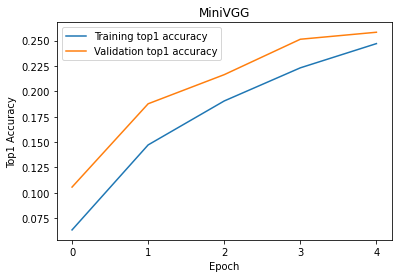

NameError: ignored

In [ ]:
# visualize the training / validation accuracies

x = np.arange(num_epochs)

# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, tr_his)
plt.plot(x, val_his)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, tr_his_BN)
plt.plot(x, val_his_BN)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, val_his)
plt.plot(x, val_his_BN)
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

###__Summarize the effect of batch normalization:__

Please write a few sentences here to summarize the effect of batch nomalization.

## Step 5. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [ ]:
def accuracy(output, target, topk=(1,)):
    '''
    Computes the accuracy over the k top predictions for the specified values of k.
    
    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.
    
    Returns:
    
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    '''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [ ]:
##### To pass the test, both networks should have Top-5 accuracy above 50% #####
# uncomment these two lines to load pretrained weights
# vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

#test(vgg_BN, dataloaders['test'])
test(vgg, dataloaders['test'])

Top-1 accuracy 25.84%, Top-5 accuracy 56.6%
